In [1]:
from __future__ import division
import sys
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, wait
from scipy import optimize as sco
from glob import glob
import re
from matplotlib.colors import LogNorm

In [2]:
nb_dir = '/home/dup193/work/double_pulse/stat_analysis'
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from likelihood import BinnedPoissonLikelihood
from event_selection import EventSelection, EventSelectionTwoBin
from helper_functions import build_histograms, build_error_histograms, plot_histogram, get_default_binning,\
build_uncert_histograms,plot_histogram_ratio
from stats import sample_from_hist,ts_to_pval
from signal_injector import SignalInjectorOneBin
from scan_neyman_plane import scan_neyman_plane,scan_neyman_plane_OneBin
from limit_calculator import LimitCalculatorNoDF

In [3]:
data_tc0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuTau_1_1.npy',mmap_mode='r')
data_tn0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuTau_2_1.npy',mmap_mode='r')
data_mc0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuMu_1_1.npy',mmap_mode='r')
data_mn0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuMu_2_1.npy',mmap_mode='r')
data_ec0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuE_1_1.npy',mmap_mode='r')
data_en0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuE_2_1.npy',mmap_mode='r')
data_eg0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuE_3_1.npy',mmap_mode='r')
data_c0 = np.load('/fastio2/dasha/double_pulse/data_MuonGun_all.npy',mmap_mode='r')

In [4]:
data_tc,data_tn,data_mc,data_mn,data_ec,data_en,data_eg,data_c = \
    EventSelection(data_tc0,data_tn0,data_mc0,data_mn0,data_ec0,data_en0,data_eg0,data_c0)
print(data_tc0.shape,data_tn0.shape,data_mc0.shape,data_mn0.shape,data_ec0.shape,data_en0.shape,data_eg0.shape,data_c0.shape)
print(data_tc.shape,data_tn.shape,data_mc.shape,data_mn.shape,data_ec.shape,data_en.shape,data_eg.shape,data_c.shape)

(128278,) (27754,) (462405,) (54601,) (420185,) (72626,) (4267,) (246367,)
(8311,) (47,) (330,) (105,) (66,) (62,) (20,) (245,)


In [5]:
weight_name = 'weight_val_0'
weight_name_c = 'weight_val'
wtype = 'nom'
secs_per_year = 31536000
years = 10

sig = sum(data_tc[weight_name][wtype]*secs_per_year*years)
bkg =  sum(data_tn[weight_name][wtype]*secs_per_year*years)+sum(data_mc[weight_name][wtype]*secs_per_year*years)+\
 sum(data_mn[weight_name][wtype]*secs_per_year*years)+ sum(data_ec[weight_name][wtype]*secs_per_year*years)+\
 sum(data_en[weight_name][wtype]*secs_per_year*years)+ sum(data_eg[weight_name][wtype]*secs_per_year*years)+\
 sum(data_c[weight_name_c]*secs_per_year*years)
print(sig,bkg)

6.834409440215124 0.32878957793130864


In [6]:
n_jobs=100
n_samples=100000
mu_bins = np.linspace(0, 25, 1001)
ts_bins = np.linspace(0, 200, 2001)
ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
out_path ="/home/dup193/work/double_pulse/onebin_test/ts_dist/"

In [ ]:
hists, ts_e = scan_neyman_plane_OneBin(sig, bkg, bkg, mu_bins, ts_bins, n_samples, n_jobs=n_jobs, save=True, out_path=out_path)

In [7]:
from glob import glob
import re
name_out = "/home/dup193/work/double_pulse/onebin_test/ts_dist/"
mat = []
hists = np.zeros((len(mu_bins), len(ts_bins) - 1))
for file_name in glob(name_out+'*'):
    sp = re.split('_|\.|/',file_name)
    mu = float(sp[-3]+"."+sp[-2])
    i = np.where(mu_bins==mu)
    x = np.load(file_name, mmap_mode="r")['arr_0']
    #print(x)
    hist, ts_e = np.histogram(x, bins=ts_bins)
    hist = hist / float(np.sum(hist))
    hists[i] = hist

In [8]:
print(hists)

[[0.71861 0.      0.      ... 0.      0.      0.     ]
 [0.70153 0.      0.      ... 0.      0.      0.     ]
 [0.68386 0.      0.      ... 0.      0.      0.     ]
 ...
 [0.23632 0.21011 0.06825 ... 0.      0.      0.     ]
 [0.23564 0.21127 0.06715 ... 0.      0.      0.     ]
 [0.23283 0.21123 0.06708 ... 0.      0.      0.     ]]


In [9]:
def plot_ts(hists):
    vmin = np.min([np.min(hist) for hist in hists])
    vmax = np.max([np.max(hist) for hist in hists])
    fig = plt.figure(figsize=(10, 10),facecolor ='w')
    plt.rcParams.update({'font.size': 16})
    plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
    ax = fig.add_subplot()
    ax.set_xlim(0,25)
    for i in range(len(mu_bins) - 1):
        Xe, Ye = np.meshgrid(ts_bins, [mu_bins[i], mu_bins[i+1]])
        im = ax.pcolormesh(Xe, Ye, np.atleast_2d(hists[i]), vmin=vmin+1e-4, vmax=vmax, norm=LogNorm())
    plt.colorbar(im)
    ax.set_xlabel('TS: $-\log(\mathcal{L}(\mu_t) / \mathcal{L}(\hat{\mu}))$')
    ax.set_ylabel(r'Mean signal expectation $\mu_t$')
    # plt.savefig('plots/neyman_plane_hans.pdf', bbox_inches='tight')
    #ax.imshow(hists,origin='lower',interpolation='none', extent=[0,20,0,20])

/home/dup193/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


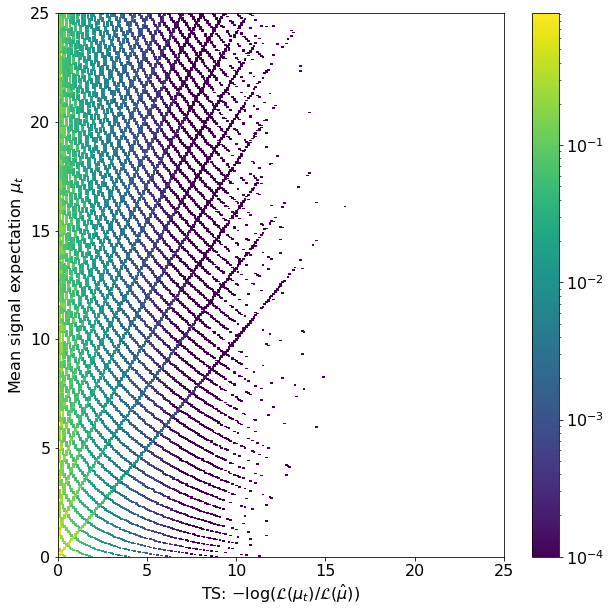

In [10]:
plot_ts(hists)

In [11]:
lc_1 = LimitCalculatorNoDF(
    'baseline', flux_systematic=False,sig = sig, bkg =bkg, 
     scan_path='/home/dup193/work/double_pulse/onebin_test/ts_dist/',
     livetime=1)

In [12]:
likelihood = BinnedPoissonLikelihood(lc_1.sig, lc_1.bkg, lc_1.random_state)
lc_1.set_likelihood(likelihood)

In [13]:
tss_1 = lc_1.__load_acceptance_values__(return_ts=True)
mus = lc_1.mus

In [14]:
def load_ts(tss):
    ts_bins = np.linspace(0, 200, 2001)
    ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
    hists = []
    for i in range(len(mus)):
        hist_i, edges = np.histogram(tss[i], bins=ts_bins, density=False)
        hist_i = hist_i / float(np.sum(hist_i))
        hists.append(hist_i)
    return hists

In [15]:
ts1_hist = load_ts(tss_1)

In [16]:
samples_bkg_1 = lc_1.create_samples(onebin = True)

In [27]:
def find_int_trials(samples):
    print('max',np.max(samples),np.argmax(samples))
    print('min',np.min(samples),np.argmin(samples))
    return np.argmax(samples), np.argmin(samples)
  

In [32]:
maxt,mint = find_int_trials(samples_bkg_1)

max 4 928
min 0 0


(array([724., 228.,  43.,   5.]),
 array([0., 1., 2., 3., 4.]),
 <a list of 4 Patch objects>)

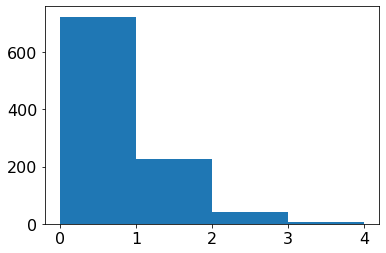

In [33]:
plt.hist(samples_bkg_1, bins = 4)

In [34]:
def plot_ts_acval(limit_calculator,hists,samples_bkg,n1,n2):
    fig = plt.figure(figsize=(10, 10),facecolor ='w')
    vmin = np.min([np.min(hist) for hist in hists])
    vmax = np.max([np.max(hist) for hist in hists])

    ts_vals = []
    for mu in mus:
        lmd = mu / limit_calculator.sig_exp
        ts_val, lmd = likelihood.fit_lmd_best(lmd, samples_bkg[n1])
        ts_vals.append(-ts_val)
    
    ts_vals2 = []
    for mu in mus:
        lmd = mu / limit_calculator.sig_exp
        ts_val, lmd = likelihood.fit_lmd_best(lmd, samples_bkg[n2])
        ts_vals2.append(-ts_val)

    fig, ax = plt.subplots(figsize=(10, 10),facecolor ='w')
    for i in range(len(mus) - 1):
        Xe, Ye = np.meshgrid(ts_bins, [mus[i], mus[i+1]])
        im = ax.pcolormesh(Xe, Ye, np.atleast_2d(hists[i]), norm=LogNorm())# , vmin=vmin+1e-4, vmax=vmax
    plt.plot(ts_vals, mus, color='k', label='Scan for example experiment')
    plt.plot(ts_vals2, mus, color='k', ls='--', label='Scan for example experiment')
    plt.plot(limit_calculator.acc_vals, mus, color='r', label='Critical values')
    ax.set_xlabel('TS: $-\log(\mathcal{L}(\mu_t) / \mathcal{L}(\hat{\mu}))$')
    ax.set_ylabel(r'Mean signal expectation $\mu_t$')
    plt.xlim(0, 20)
    ylim_lower = 0
    ylim_upper = 20
    plt.ylim(ylim_lower, ylim_upper)
    plt.legend()
    ax2 = ax.twinx()
    ax2.set_ylabel(r'Mean rel. $\nu_{\tau}$ flux norm $\lambda_t$')
    ax2.plot(ts_vals2, mus/limit_calculator.sig_exp, color='k', ls='--', label='Scan for example experiment')
    ax2.set_ylim(ylim_lower/limit_calculator.sig_exp, ylim_upper/limit_calculator.sig_exp)
    plt.colorbar(im, pad=0.15)

<Figure size 720x720 with 0 Axes>

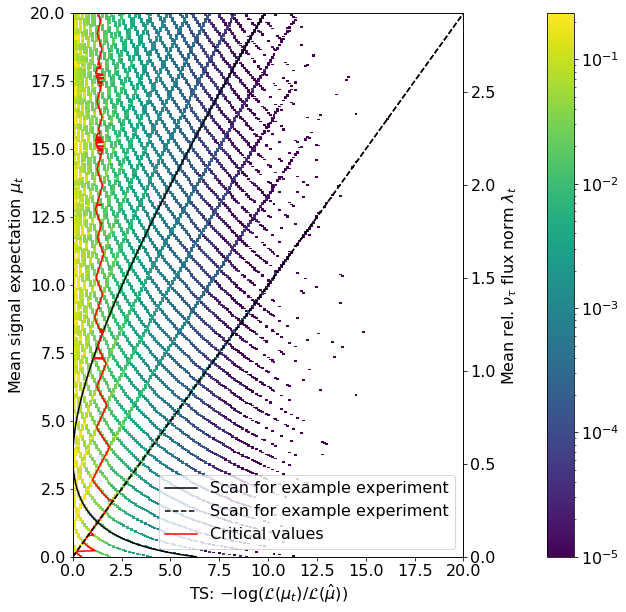

In [35]:
plot_ts_acval(lc_1,ts1_hist,samples_bkg_1,maxt,mint)

In [36]:
flux_norm = 2.12
#flux_norm = 2.23
#flux_norm = 1.36
lc_1.calculate_limits(lc_1.acc_vals, flux_norm)

100%|██████████| 1000/1000 [00:16<00:00, 60.86it/s]


In [37]:
print(lc_1.average_upper_limit)
print(np.std(lc_1.upper_limits_flux))

0.8300044136397903
0.3158711729924104


In [38]:
np.sum(lc_1.lower_limits_flux==0)/len(lc_1.lower_limits_flux)

0.952

Text(0.5, 1.0, 'Fitting with $E^{-2.87}$')

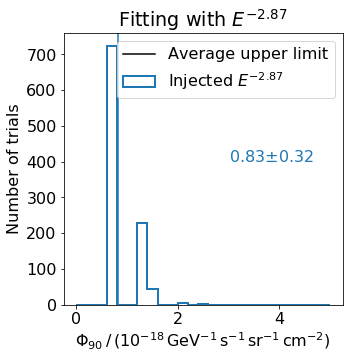

In [39]:
fig = plt.figure(figsize=(5, 5),facecolor ='w')
ul_bins = np.linspace(0, 5, 26)
plt.hist(lc_1.upper_limits_flux, bins=ul_bins, histtype='step', lw=2, label='Injected $E^{-2.87}$')
plt.axvline(lc_1.average_upper_limit)

plt.text(3,400, "{0:.2f}$\pm${1:.2f}".format(lc_1.average_upper_limit,np.std(lc_1.upper_limits_flux)), color = 'C0')

plt.legend(fontsize = 'x-small')
plt.plot([], [], color='k', ls='-', label='Average upper limit')
plt.legend()
plt.xlabel('$\Phi_{90} \, / \, (10^{-18} \, \mathrm{GeV}^{-1} \, \mathrm{s}^{-1} \, \mathrm{sr}^{-1} \, \mathrm{cm}^{-2})$')
plt.ylabel('Number of trials')
plt.title('Fitting with $E^{-2.87}$')